In [1]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from preprocessing import get_clean_data
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
from sklearn.ensemble import IsolationForest
from score import get_labels
from score import calc_precision, calc_recall
import gc
from tqdm import tqdm_notebook
from functools import reduce

## XGBoost Regression

In [197]:
xgb_thresh_gen = pd.read_csv('/mnt/HARD/MinMax94/models/results/xgb_thresh_gen.csv')
xgb_thresh_opt = pd.read_csv('/mnt/HARD/MinMax94/models/results/xgb_thresh_opt.csv')
xgb_thresh = pd.merge(xgb_thresh_gen, xgb_thresh_opt, on=['Threshold'], suffixes=('_gen', '_opt'))
xgb_thresh['Threshold'] = xgb_thresh['Threshold'] * 0.889

to_plot = copy(xgb_thresh)

opt_max_f1 = to_plot['F1_opt'].max()
opt_max_point = to_plot['Threshold'][to_plot['F1_opt'] == opt_max_f1].iloc[0]

gen_max_f1 = to_plot['F1_gen'].max()
gen_max_point = to_plot['Threshold'][to_plot['F1_gen'] == gen_max_f1].iloc[0]

artificial_max_point = gen_max_point
artificial_f1 = to_plot[to_plot['Threshold'] == artificial_max_point]['F1_opt']

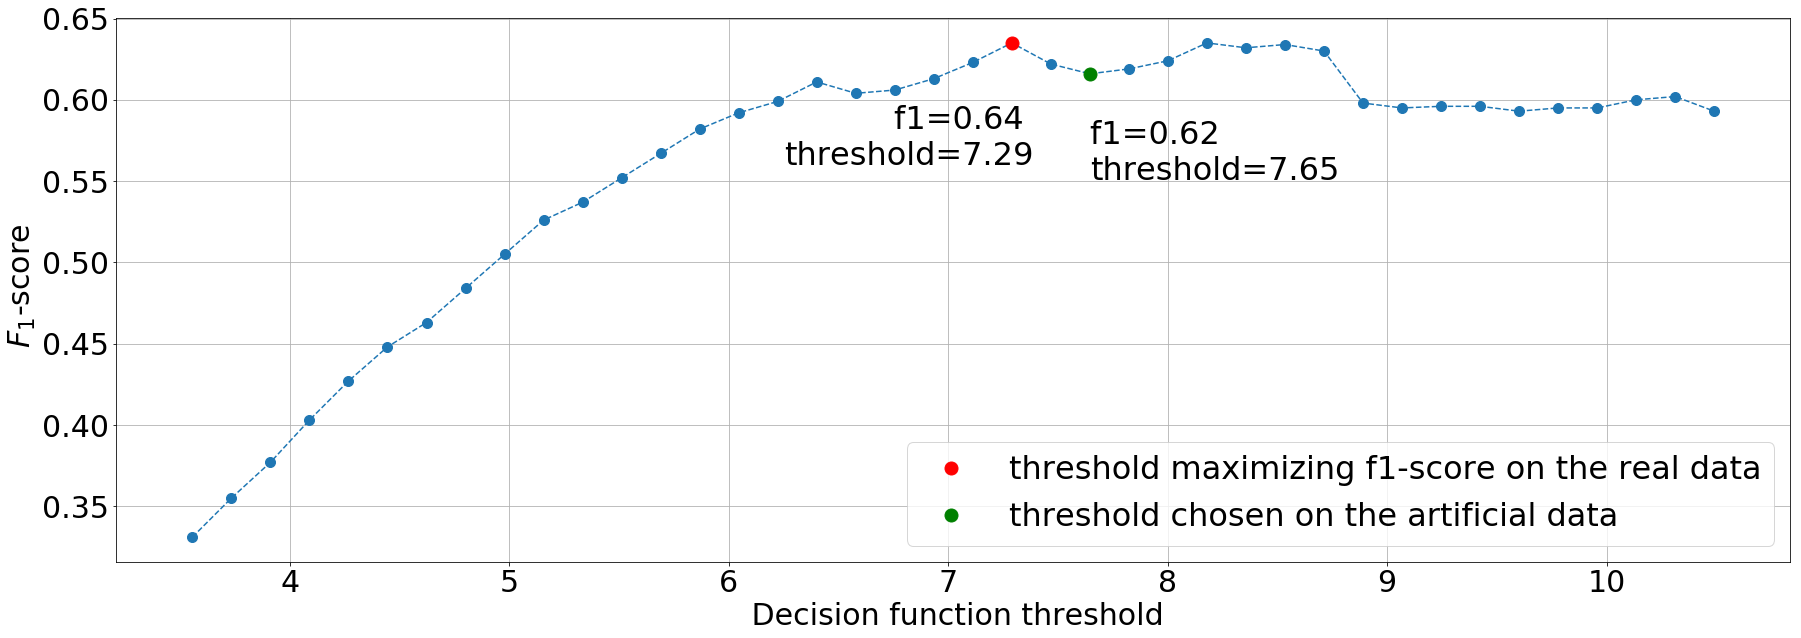

In [198]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))

plt.plot(to_plot['Threshold'], to_plot['F1_opt'],
                    linestyle='--', marker='o', markersize=10, label='')

style = dict(size=32, color='black')

plt.plot(opt_max_point, opt_max_f1, linestyle='none', marker='o', markersize=13, 
         c='r', label='threshold maximizing f1-score on the real data')

plt.plot(artificial_max_point, artificial_f1, linestyle='none', marker='o', markersize=13, 
        c='g', label='threshold chosen on the artificial data')

plt.text(opt_max_point + 0.1, opt_max_f1 - 0.075, 
        'f1={0:.2f} \nthreshold={1:.2f}'.format(opt_max_f1, opt_max_point), ha='right', **style)

plt.text(artificial_max_point, artificial_f1 - 0.065, 
         'f1={0:.2f} \nthreshold={1:.2f}'.format(artificial_f1.values[0], artificial_max_point), ha='left', **style)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' $F_1$-score',fontsize=30)
plt.xlabel(r' Decision function threshold',fontsize=30)

plt.tick_params(labelsize=30)
plt.show()
#plt.savefig('/mnt/HARD/MinMax94/plots/xgb_thresh_opt.png')

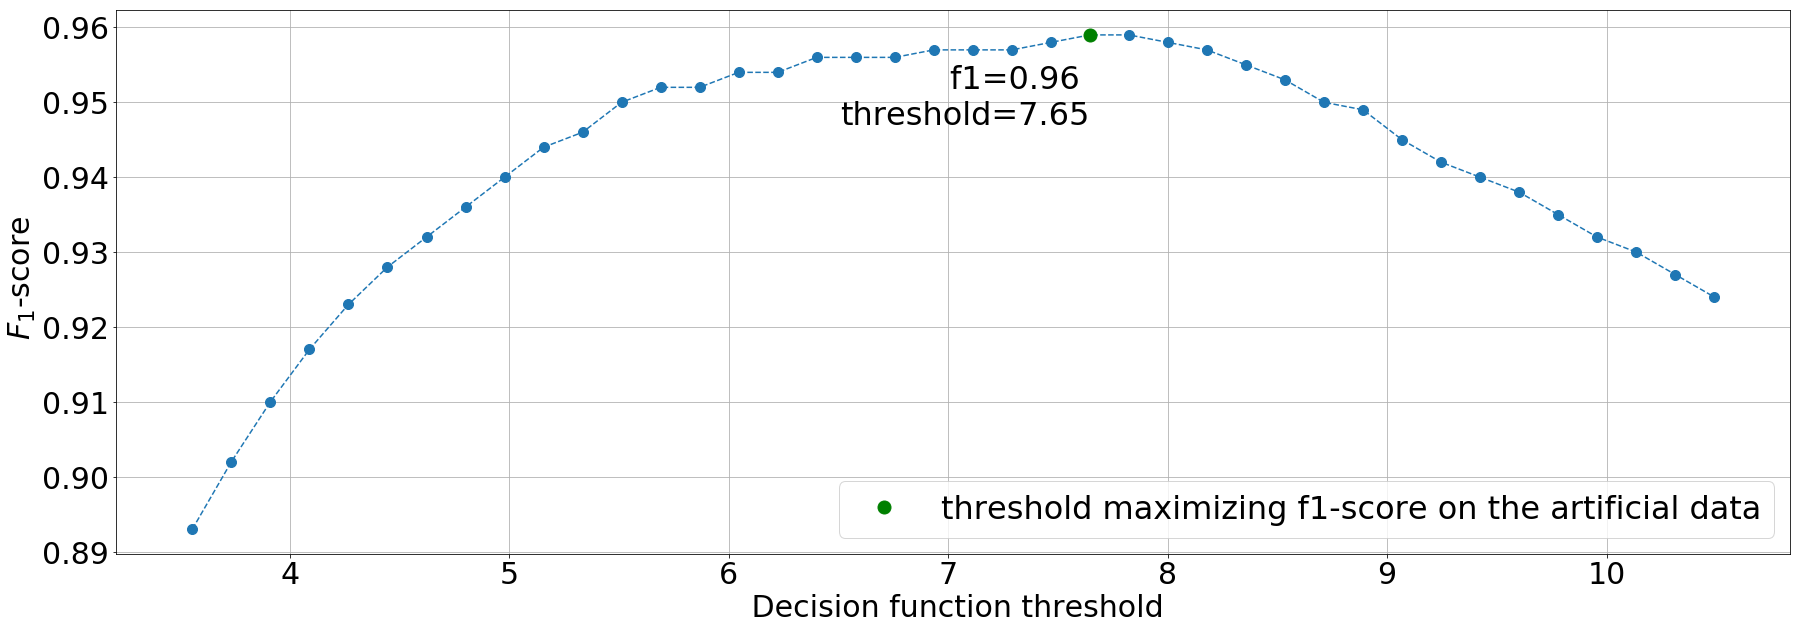

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))

plt.plot(to_plot['Threshold'], to_plot['F1_gen'],
                linestyle='--', marker='o', markersize=10, label='')

style = dict(size=32, color='black')

plt.plot(gen_max_point, gen_max_f1, linestyle='none', marker='o', markersize=13, c='g', 
         label='threshold maximizing f1-score on the artificial data')
plt.text(gen_max_point, gen_max_f1 - 0.012, 
         'f1={0:.2f} \nthreshold={1:.2f}'.format(gen_max_f1, gen_max_point), ha='right', **style)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' $F_1$-score',fontsize=30)
plt.xlabel(r' Decision function threshold',fontsize=30)

plt.tick_params(labelsize=30)
plt.show()
#plt.savefig('/mnt/HARD/MinMax94/plots/xgb_thresh_gen.png')

## XGBoost Regression Noisy

In [11]:
xgb_n_thresh_gen = pd.read_csv('/mnt/HARD/MinMax94/models/results/xgb_n_thresh_gen.csv')
xgb_n_thresh_opt = pd.read_csv('/mnt/HARD/MinMax94/models/results/xgb_n_thresh_opt.csv')
xgb_n_thresh = pd.merge(xgb_n_thresh_gen, xgb_n_thresh_opt, on=['Threshold'], suffixes=('_gen', '_opt'))
xgb_n_thresh['Threshold'] = xgb_n_thresh['Threshold'] * 0.889

to_plot = copy(xgb_n_thresh)

opt_max_f1 = to_plot['F1_opt'].max()
opt_max_point = to_plot['Threshold'][to_plot['F1_opt'] == opt_max_f1].iloc[0]

gen_max_f1 = to_plot['F1_gen'].max()
gen_max_point = to_plot['Threshold'][to_plot['F1_gen'] == gen_max_f1].iloc[0]

artificial_max_point = gen_max_point
artificial_f1 = to_plot[to_plot['Threshold'] == artificial_max_point]['F1_opt']

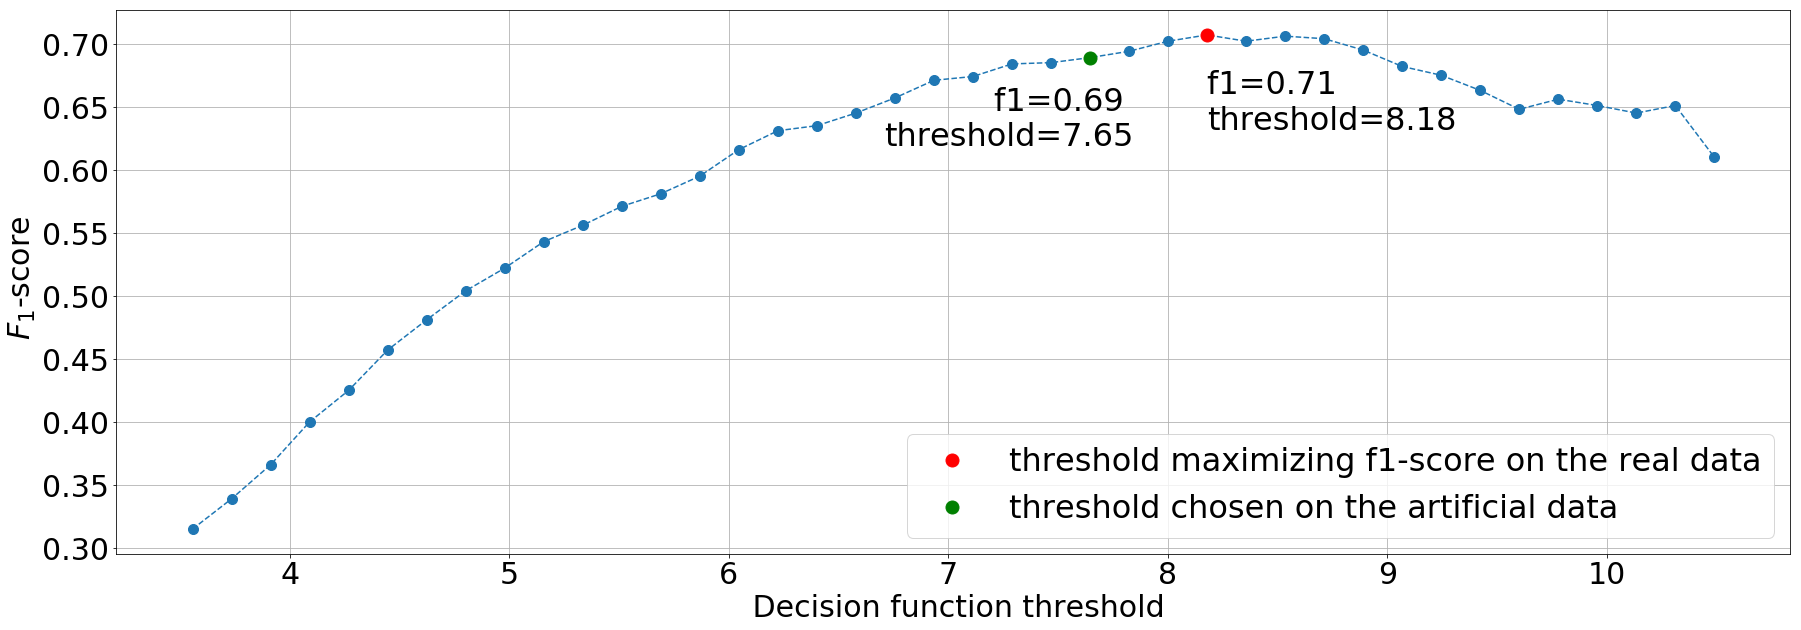

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))

plt.plot(to_plot['Threshold'], to_plot['F1_opt'],
                    linestyle='--', marker='o', markersize=10, label='')

style = dict(size=32, color='black')

plt.plot(opt_max_point, opt_max_f1, linestyle='none', marker='o', markersize=13, 
         c='r', label='threshold maximizing f1-score on the real data')

plt.plot(artificial_max_point, artificial_f1, linestyle='none', marker='o', markersize=13, 
        c='g', label='threshold chosen on the artificial data')

plt.text(opt_max_point, opt_max_f1 - 0.075, 
        'f1={0:.2f} \nthreshold={1:.2f}'.format(opt_max_f1, opt_max_point), ha='left', **style)

plt.text(artificial_max_point + 0.2, artificial_f1 - 0.07, 
         'f1={0:.2f} \nthreshold={1:.2f}'.format(artificial_f1.values[0], artificial_max_point), ha='right', **style)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' $F_1$-score',fontsize=30)
plt.xlabel(r' Decision function threshold',fontsize=30)

plt.tick_params(labelsize=30)
plt.show()
#plt.savefig('/mnt/HARD/MinMax94/plots/xgb_n_thresh_opt.png')

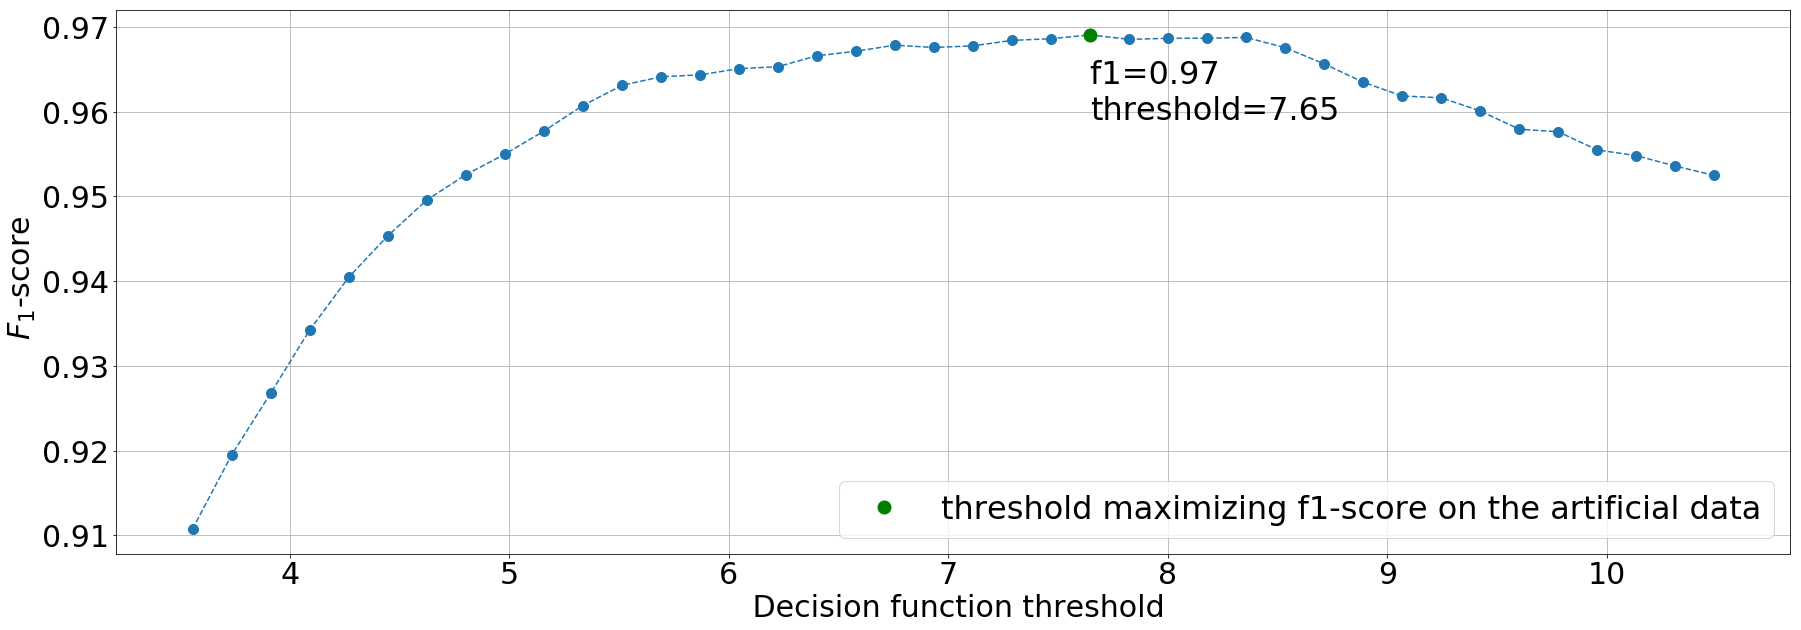

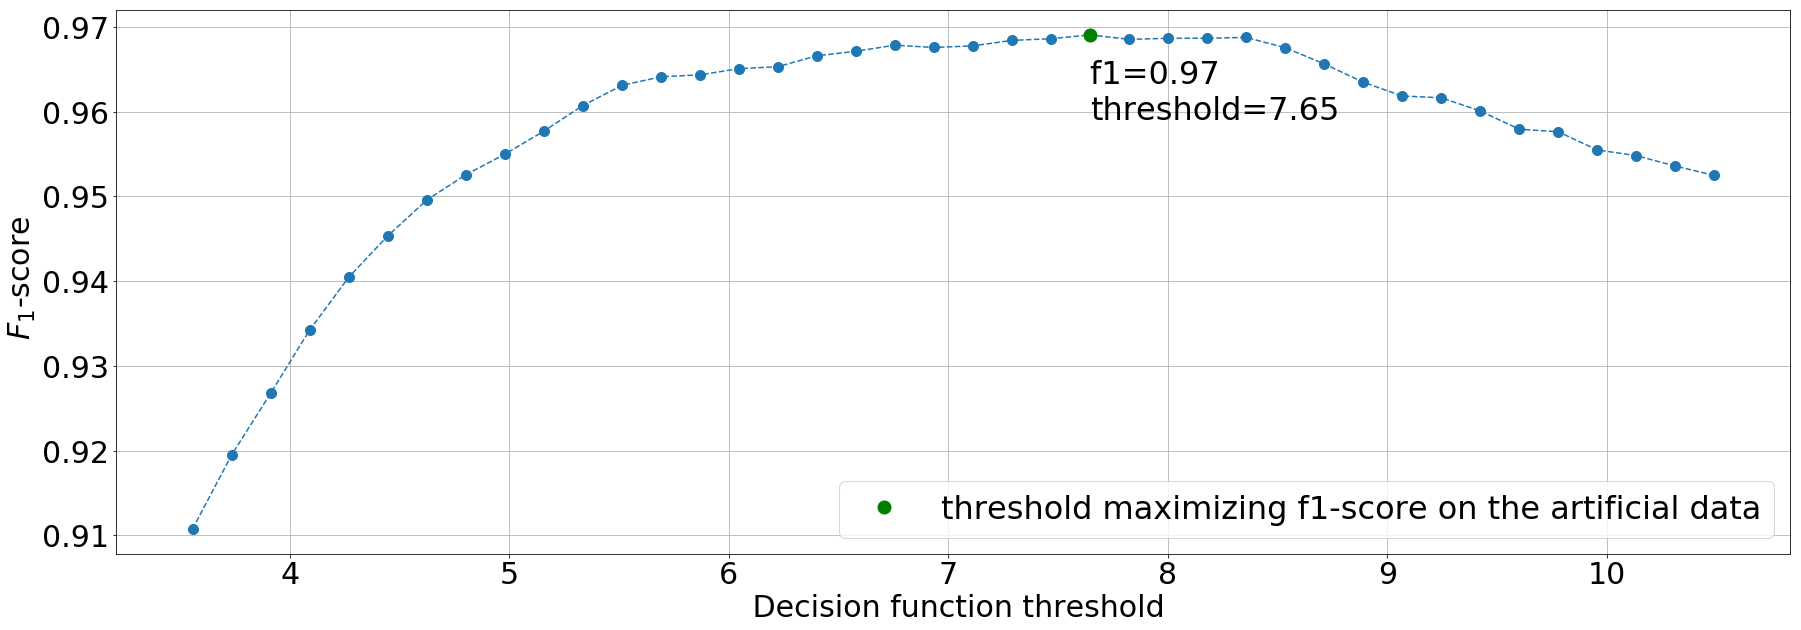

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))

plt.plot(to_plot['Threshold'], to_plot['F1_gen'],
                linestyle='--', marker='o', markersize=10, label='')

style = dict(size=32, color='black')

plt.plot(gen_max_point, gen_max_f1, linestyle='none', marker='o', markersize=13, c='g', 
         label='threshold maximizing f1-score on the artificial data')
plt.text(gen_max_point, gen_max_f1 - 0.01, 'f1={0:.2f} \nthreshold={1:.2f}'.format(gen_max_f1, gen_max_point), ha='left', **style)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' $F_1$-score',fontsize=30)
plt.xlabel(r' Decision function threshold',fontsize=30)

plt.tick_params(labelsize=30)
plt.show()
#plt.savefig('/mnt/HARD/MinMax94/plots/xgb_n_thresh_gen.png')

## XGBoost Regression Air

In [157]:
xgb_air_thresh_gen = pd.read_csv('/mnt/HARD/MinMax94/models/results/xgb_air_thresh_gen.csv')
xgb_air_thresh_opt = pd.read_csv('/mnt/HARD/MinMax94/models/results/xgb_air_thresh_opt.csv')
xgb_air_thresh = pd.merge(xgb_air_thresh_gen, xgb_air_thresh_opt, on=['Threshold'], suffixes=('_gen', '_opt'))
xgb_air_thresh['Threshold'] = xgb_air_thresh['Threshold'] * 3.385

to_plot = copy(xgb_air_thresh)

opt_max_f1 = to_plot['F1_opt'].max()
opt_max_point = to_plot['Threshold'][to_plot['F1_opt'] == opt_max_f1].iloc[0]

gen_max_f1 = to_plot['F1_gen'].max()
gen_max_point = to_plot['Threshold'][to_plot['F1_gen'] == gen_max_f1].iloc[0]

artificial_max_point = gen_max_point
artificial_f1 = to_plot[to_plot['Threshold'] == artificial_max_point]['F1_opt']

In [159]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))

plt.plot(to_plot['Threshold'], to_plot['F1_opt'],
                    linestyle='--', marker='o', markersize=10, label='')

style = dict(size=32, color='black')

plt.plot(opt_max_point, opt_max_f1, linestyle='none', marker='o', markersize=13, 
         c='r', label='threshold maximizing f1-score on the real data')

plt.plot(artificial_max_point, artificial_f1, linestyle='none', marker='o', markersize=13, 
        c='g', label='threshold chosen on the artificial data')

plt.text(opt_max_point, opt_max_f1 - 0.1, 
        'f1={0:.2f} \nthreshold={1:.2f}'.format(opt_max_f1, opt_max_point), ha='left', **style)

plt.text(artificial_max_point + 1.6, artificial_f1 - 0.1, 
         'f1={0:.2f} \nthreshold={1:.2f}'.format(artificial_f1.values[0], artificial_max_point), ha='right', **style)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' $F_1$-score',fontsize=30)
plt.xlabel(r' Decision function threshold',fontsize=30)

plt.tick_params(labelsize=30)
plt.show()
#plt.savefig('/mnt/HARD/MinMax94/plots/xgb_air_thresh_opt.png')

In [162]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))

plt.plot(to_plot['Threshold'], to_plot['F1_gen'],
                linestyle='--', marker='o', markersize=10, label='')

style = dict(size=32, color='black')

plt.plot(gen_max_point, gen_max_f1, linestyle='none', marker='o', markersize=13, c='g', 
         label='threshold maximizing f1-score on the artificial data')

plt.text(gen_max_point - 0.05, gen_max_f1 - 0.06, 'f1={0:.2f} \nthreshold={1:.2f}'.format(gen_max_f1, gen_max_point), 
         ha='center', **style)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' $F_1$-score',fontsize=30)
plt.xlabel(r' Decision function threshold',fontsize=30)

plt.tick_params(labelsize=30)
plt.show()
#plt.savefig('/mnt/HARD/MinMax94/plots/xgb_air_thresh_gen.png')

## Ridge Regression

In [163]:
ridge_thresh_gen = pd.read_csv('/mnt/HARD/MinMax94/models/results/ridge_thresh_gen.csv')
ridge_thresh_opt = pd.read_csv('/mnt/HARD/MinMax94/models/results/ridge_thresh_opt.csv')
ridge_thresh = pd.merge(ridge_thresh_gen, ridge_thresh_opt, on=['Threshold'], suffixes=('_gen', '_opt'))
ridge_thresh['Threshold'] = ridge_thresh['Threshold'] * 0.876

to_plot = copy(ridge_thresh)

opt_max_f1 = to_plot['F1_opt'].max()
opt_max_point = to_plot['Threshold'][to_plot['F1_opt'] == opt_max_f1].iloc[0]

gen_max_f1 = to_plot['F1_gen'].max()
gen_max_point = to_plot['Threshold'][to_plot['F1_gen'] == gen_max_f1].iloc[0]

artificial_max_point = gen_max_point
artificial_f1 = to_plot[to_plot['Threshold'] == artificial_max_point]['F1_opt']

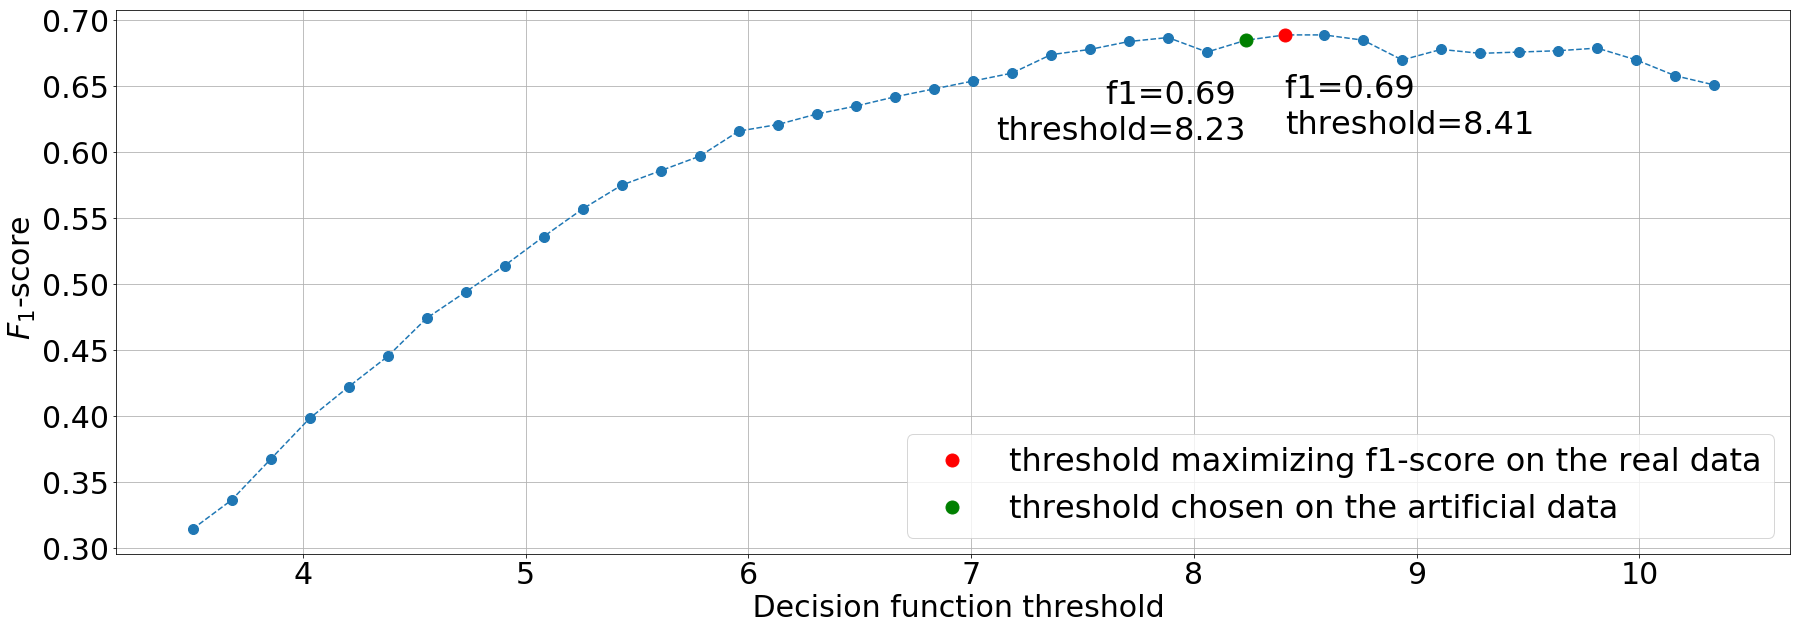

In [169]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))

plt.plot(to_plot['Threshold'], to_plot['F1_opt'],
                    linestyle='--', marker='o', markersize=10, label='')

style = dict(size=32, color='black')

plt.plot(opt_max_point, opt_max_f1, linestyle='none', marker='o', markersize=13, 
         c='r', label='threshold maximizing f1-score on the real data')

plt.plot(artificial_max_point, artificial_f1, linestyle='none', marker='o', markersize=13, 
        c='g', label='threshold chosen on the artificial data')

plt.text(opt_max_point, opt_max_f1 - 0.075, 
        'f1={0:.2f} \nthreshold={1:.2f}'.format(opt_max_f1, opt_max_point), ha='left', **style)

plt.text(artificial_max_point, artificial_f1 - 0.075, 
         'f1={0:.2f} \nthreshold={1:.2f}'.format(artificial_f1.values[0], artificial_max_point), ha='right', **style)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' $F_1$-score',fontsize=30)
plt.xlabel(r' Decision function threshold',fontsize=30)

plt.tick_params(labelsize=30)
plt.show()
#plt.savefig('/mnt/HARD/MinMax94/plots/ridge_thresh_opt.png')

In [171]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))

plt.plot(to_plot['Threshold'], to_plot['F1_gen'],
                linestyle='--', marker='o', markersize=10, label='')

style = dict(size=32, color='black')

plt.plot(gen_max_point, gen_max_f1, linestyle='none', marker='o', markersize=13, c='g', 
         label='threshold maximizing f1-score on the artificial data')
plt.text(gen_max_point, gen_max_f1 - 0.015, 'f1={0:.2f} \nthreshold={1:.2f}'.format(gen_max_f1, gen_max_point), ha='left', **style)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' $F_1$-score',fontsize=30)
plt.xlabel(r' Decision function threshold',fontsize=30)

plt.tick_params(labelsize=30)
plt.show()
#plt.savefig('/mnt/HARD/MinMax94/plots/ridge_thresh_gen.png')

## Average

In [172]:
average_thresh_gen = pd.read_csv('/mnt/HARD/MinMax94/models/results/average_thresh_gen.csv')
average_thresh_opt = pd.read_csv('/mnt/HARD/MinMax94/models/results/average_thresh_opt.csv')
average_thresh = pd.merge(average_thresh_gen, average_thresh_opt, on=['Threshold'], suffixes=('_gen', '_opt'))
average_thresh['Threshold'] = average_thresh['Threshold']

to_plot = copy(average_thresh)

opt_max_f1 = to_plot['F1_opt'].max()
opt_max_point = to_plot['Threshold'][to_plot['F1_opt'] == opt_max_f1].iloc[0]

gen_max_f1 = to_plot['F1_gen'].max()
gen_max_point = to_plot['Threshold'][to_plot['F1_gen'] == gen_max_f1].iloc[0]

artificial_max_point = gen_max_point
artificial_f1 = to_plot[to_plot['Threshold'] == artificial_max_point]['F1_opt']

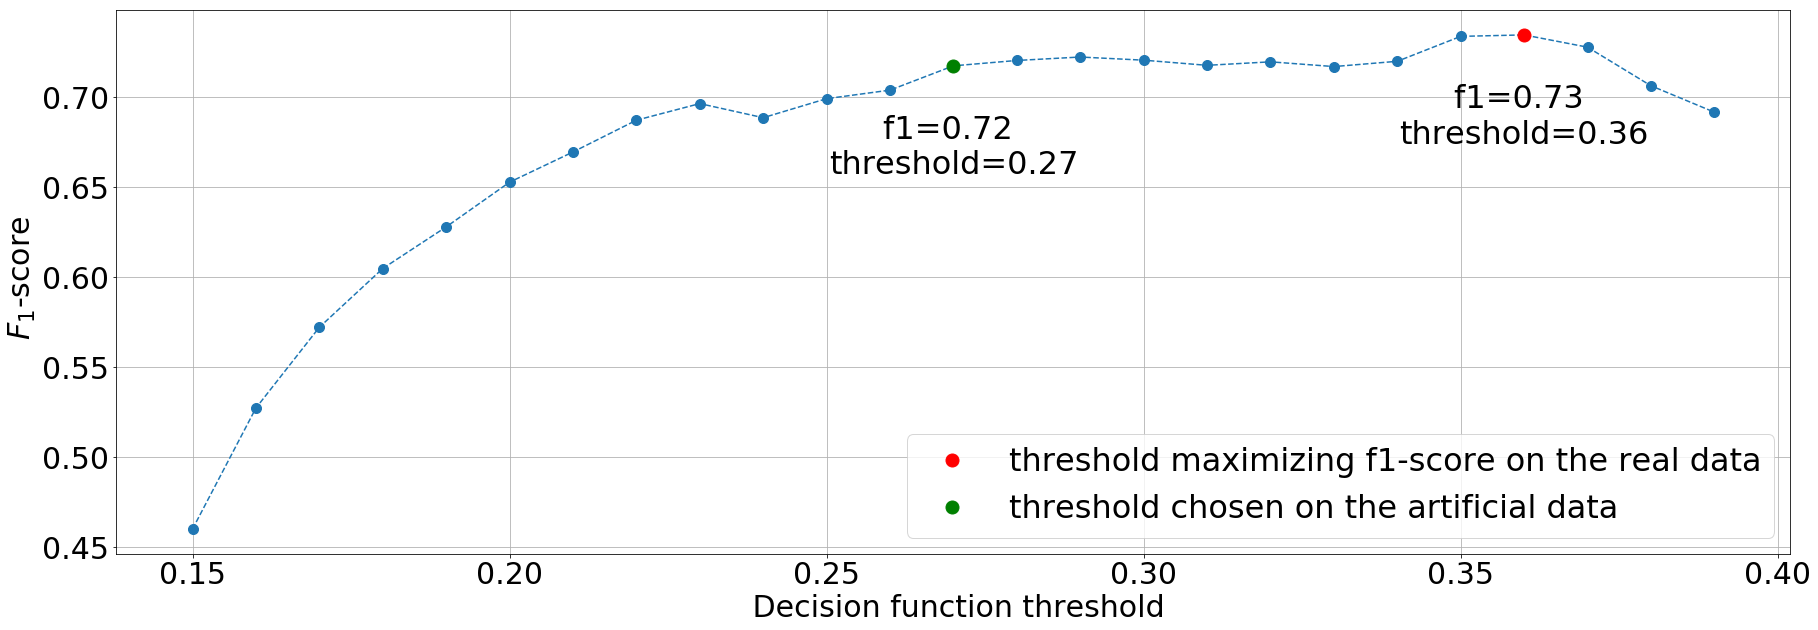

In [180]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))

plt.plot(to_plot['Threshold'], to_plot['F1_opt'],
                    linestyle='--', marker='o', markersize=10, label='')

style = dict(size=32, color='black')

plt.plot(opt_max_point, opt_max_f1, linestyle='none', marker='o', markersize=13, 
         c='r', label='threshold maximizing f1-score on the real data')

plt.plot(artificial_max_point, artificial_f1, linestyle='none', marker='o', markersize=13, 
        c='g', label='threshold chosen on the artificial data')

plt.text(opt_max_point, opt_max_f1 - 0.06, 
        'f1={0:.2f} \nthreshold={1:.2f}'.format(opt_max_f1, opt_max_point), ha='center', **style)

plt.text(artificial_max_point, artificial_f1 - 0.06, 
         'f1={0:.2f} \nthreshold={1:.2f}'.format(artificial_f1.values[0], artificial_max_point), ha='center', **style)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' $F_1$-score',fontsize=30)
plt.xlabel(r' Decision function threshold',fontsize=30)

plt.tick_params(labelsize=30)
plt.show()
#plt.savefig('/mnt/HARD/MinMax94/plots/average_thresh_opt.png')

In [181]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))

plt.plot(to_plot['Threshold'], to_plot['F1_gen'],
                linestyle='--', marker='o', markersize=10, label='')

style = dict(size=32, color='black')

plt.plot(gen_max_point, gen_max_f1, linestyle='none', marker='o', markersize=13, c='g', 
         label='threshold maximizing f1-score on the artificial data')
plt.text(gen_max_point, gen_max_f1 - 0.03, 'f1={0:.2f} \nthreshold={1:.2f}'.format(gen_max_f1, gen_max_point), ha='left', **style)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' $F_1$-score',fontsize=30)
plt.xlabel(r' Decision function threshold',fontsize=30)

plt.tick_params(labelsize=30)
plt.show()
#plt.savefig('/mnt/HARD/MinMax94/plots/average_thresh_gen.png')

## Weighted

In [201]:
weighted_thresh_gen = pd.read_csv('/mnt/HARD/MinMax94/models/results/weighted_thresh_gen.csv')
weighted_thresh_opt = pd.read_csv('/mnt/HARD/MinMax94/models/results/weighted_thresh_opt.csv')
weighted_thresh = pd.merge(weighted_thresh_gen, weighted_thresh_opt, on=['Threshold'], suffixes=('_gen', '_opt'))
weighted_thresh['Threshold'] = weighted_thresh['Threshold']

to_plot = copy(weighted_thresh)

opt_max_f1 = to_plot['F1_opt'].max()
opt_max_point = to_plot['Threshold'][to_plot['F1_opt'] == opt_max_f1].iloc[0]

gen_max_f1 = to_plot['F1_gen'].max()
gen_max_point = to_plot['Threshold'][to_plot['F1_gen'] == gen_max_f1].iloc[0]

artificial_max_point = gen_max_point
artificial_f1 = to_plot[to_plot['Threshold'] == artificial_max_point]['F1_opt']

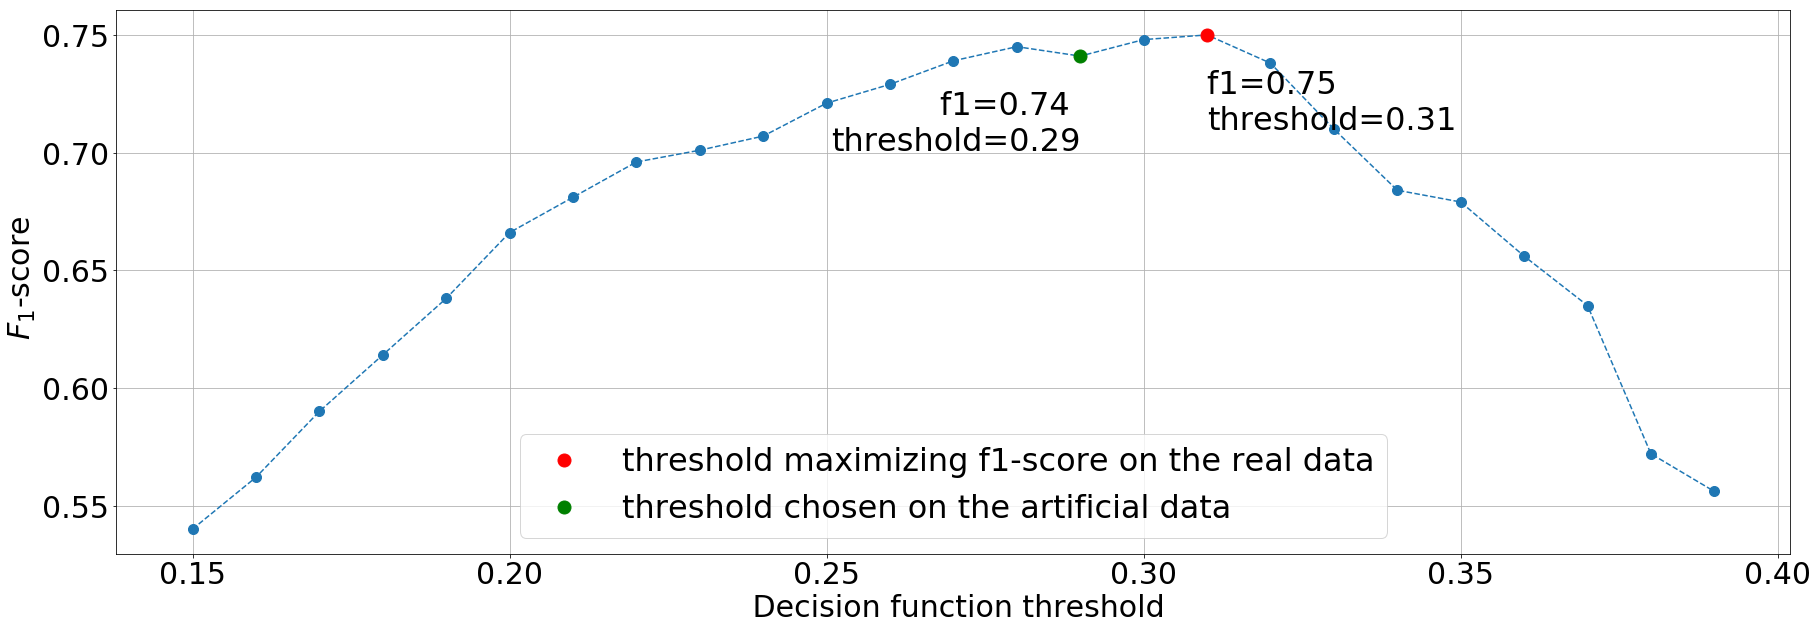

In [202]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))

plt.plot(to_plot['Threshold'], to_plot['F1_opt'],
                    linestyle='--', marker='o', markersize=10, label='')

style = dict(size=32, color='black')

plt.plot(opt_max_point, opt_max_f1, linestyle='none', marker='o', markersize=13, 
         c='r', label='threshold maximizing f1-score on the real data')

plt.plot(artificial_max_point, artificial_f1, linestyle='none', marker='o', markersize=13, 
        c='g', label='threshold chosen on the artificial data')

plt.text(opt_max_point, opt_max_f1 - 0.04, 
        'f1={0:.2f} \nthreshold={1:.2f}'.format(opt_max_f1, opt_max_point), ha='left', **style)

plt.text(artificial_max_point, artificial_f1 - 0.04, 
         'f1={0:.2f} \nthreshold={1:.2f}'.format(artificial_f1.values[0], artificial_max_point), ha='right', **style)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' $F_1$-score',fontsize=30)
plt.xlabel(r' Decision function threshold',fontsize=30)

plt.tick_params(labelsize=30)
plt.show()
#plt.savefig('/mnt/HARD/MinMax94/plots/weighted_thresh_opt.png')

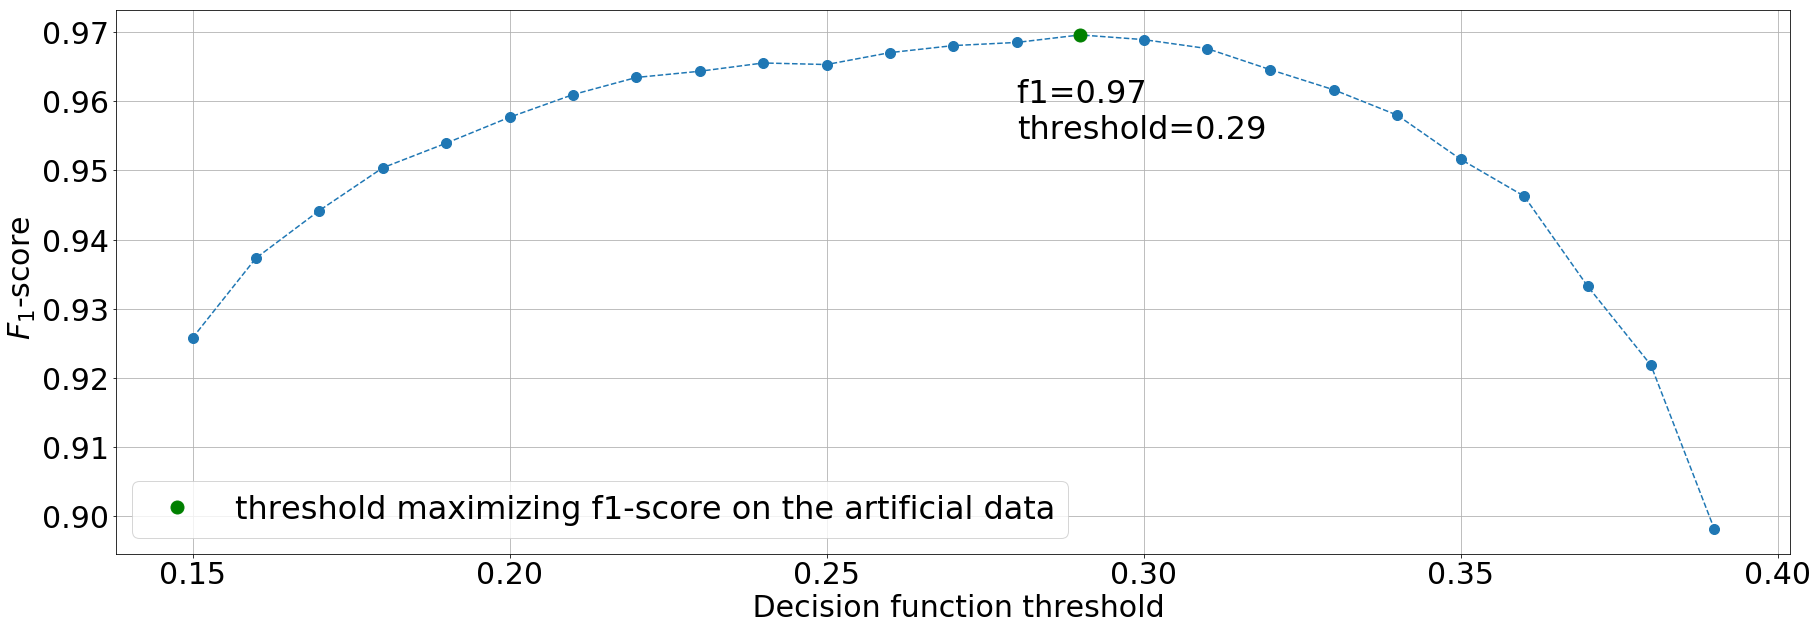

In [205]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))

plt.plot(to_plot['Threshold'], to_plot['F1_gen'],
                linestyle='--', marker='o', markersize=10, label='')

style = dict(size=32, color='black')

plt.plot(gen_max_point, gen_max_f1, linestyle='none', marker='o', markersize=13, c='g', 
         label='threshold maximizing f1-score on the artificial data')
plt.text(gen_max_point - 0.01, gen_max_f1 - 0.015, 'f1={0:.2f} \nthreshold={1:.2f}'.format(gen_max_f1, gen_max_point), ha='left', **style)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' $F_1$-score',fontsize=30)
plt.xlabel(r' Decision function threshold',fontsize=30)

plt.tick_params(labelsize=30)
plt.show()
#plt.savefig('/mnt/HARD/MinMax94/plots/weighted_thresh_gen.png')

In [106]:

weighted_thresh_gen_pd = pd.DataFrame(weighted_thresh_gen)
weighted_thresh_gen_pd['Threshold'] = weighted_thresh_gen_pd['Threshold'].round(2)
weighted_thresh_gen_pd.to_csv('/mnt/HARD/MinMax94/models/results/weighted_thresh_gen.csv', index=False)